In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [28]:
df = pd.read_csv("training_dataset.csv")

In [29]:
categorical_columns = [
    'pekerjaan', 'status_perkawinan', 'pendidikan', 'gagal_bayar_sebelumnya',
    'pinjaman_rumah', 'pinjaman_pribadi', 'jenis_kontak', 'bulan_kontak_terakhir',
    'hari_kontak_terakhir', 'hasil_kampanye_sebelumnya'
]

In [30]:
df_clean = df[~df[categorical_columns].isin(['unknown']).any(axis=1)].reset_index(drop=True)


In [31]:
y = df_clean["berlangganan_deposito"]
X = df_clean.drop(columns=["berlangganan_deposito", "customer_number"])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [33]:
numerical_features = [
    'usia', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya',
    'jumlah_kontak_sebelumnya', 'tingkat_variasi_pekerjaan',
    'indeks_harga_konsumen', 'indeks_kepercayaan_konsumen',
    'suku_bunga_euribor_3bln', 'jumlah_pekerja'
]

In [34]:
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
    ]), numerical_features),
    ('cat', Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_columns)
])

In [35]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [36]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

In [37]:
# Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_res, y_train_res)
best_rf = grid_rf.best_estimator_


# Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=3, scoring='f1', n_jobs=-1)
grid_gb.fit(X_train_res, y_train_res)
best_gb = grid_gb.best_estimator_

# Logistic Regression
param_grid_lr = {
    'C': [0.1, 1.0, 10],
    'solver': ['liblinear']
}
grid_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=3, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train_res, y_train_res)
best_lr = grid_lr.best_estimator_

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_xgb = GridSearchCV(
    xgb_base,
    param_grid_xgb,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_xgb.fit(X_train_res, y_train_res)
best_xgb = grid_xgb.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [38]:
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('rf', best_rf), 
                ('gb', best_gb), 
                ('lr', best_lr), 
                ('xgb', best_xgb),
                ],
    voting='soft'
)
voting_clf.fit(X_train_res, y_train_res)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(min_samples_split=5,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=5,
                                                         random_state=42)),
                             ('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsa...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

In [39]:
# Predict and evaluate
y_pred = voting_clf.predict(X_test_processed)
y_proba = voting_clf.predict_proba(X_test_processed)[:, 1]

In [40]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {auc_score:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2958
           1       0.51      0.48      0.50       432

    accuracy                           0.87      3390
   macro avg       0.72      0.71      0.71      3390
weighted avg       0.87      0.87      0.87      3390


ROC AUC Score: 0.8030


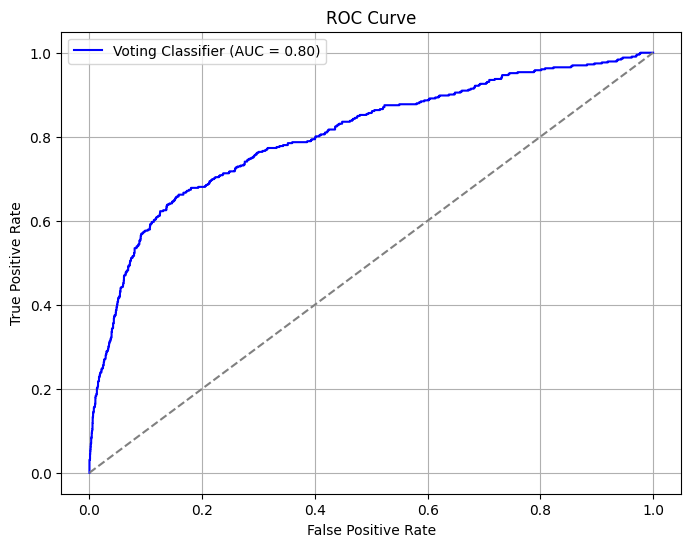

In [41]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Voting Classifier (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()